
## Electricity Price Predictive Model

This notebook presents a predictive model for electricity prices, using TTF (Title Transfer Facility) hourly gas prices as a key reference variable. The workflow will explore the relationship between gas prices and electricity market dynamics to forecast future electricity prices.



In [23]:
import pandas as pd

# Load historical TTF and electricity data
ttf_hourly = pd.read_csv('../Data/TTF_hourly_prediction.csv', parse_dates=['Date'])
elec_hourly = pd.read_csv('../Data/Netherlands.csv', parse_dates=['Datetime (UTC)'])

# Set index for both
ttf_hourly = ttf_hourly.set_index('Date')
elec_hourly = elec_hourly.set_index('Datetime (UTC)')

# Create a full hourly range covering all available historical data
full_range = pd.date_range(
    start=max(ttf_hourly.index.min(), elec_hourly.index.min()),
    end=min(ttf_hourly.index.max(), elec_hourly.index.max()),
    freq='H'
)

# Reindex both to the same hourly range
ttf_hourly = ttf_hourly.reindex(full_range)
elec_hourly = elec_hourly.reindex(full_range)

# Select relevant columns
y = elec_hourly['Price (EUR/MWhe)']
exog = ttf_hourly['Price']

# Check for missing values
print("Missing in y:", y.isnull().sum())
print("Missing in exog:", exog.isnull().sum())

/var/folders/py/tttdp81n4rj_y9mxm1f1br6r0000gn/T/ipykernel_29489/3945997172.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  elec_hourly = pd.read_csv('../Data/Netherlands.csv', parse_dates=['Datetime (UTC)'])


Missing in y: 8
Missing in exog: 0


/var/folders/py/tttdp81n4rj_y9mxm1f1br6r0000gn/T/ipykernel_29489/3945997172.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(


In [24]:
mask = (~y.isnull()) & (~exog.isnull())
y_clean = y[mask]
exog_clean = exog[mask]

print("After dropping missing values:")
print("y_clean shape:", y_clean.shape)
print("exog_clean shape:", exog_clean.shape)

# Optionally, preview the cleaned data
y_clean.head(), exog_clean.head()

After dropping missing values:
y_clean shape: (56485,)
exog_clean shape: (56485,)


(2019-01-02 00:00:00    46.60
 2019-01-02 01:00:00    46.60
 2019-01-02 02:00:00    45.73
 2019-01-02 03:00:00    46.01
 2019-01-02 04:00:00    46.45
 Name: Price (EUR/MWhe), dtype: float64,
 2019-01-02 00:00:00    22.280000
 2019-01-02 01:00:00    22.346840
 2019-01-02 02:00:00    22.413767
 2019-01-02 03:00:00    22.480783
 2019-01-02 04:00:00    22.547887
 Name: Price, dtype: float64)

In [41]:
# Step 3: Split data into training and test sets using a specific date

test_start_date = pd.Timestamp('2024-01-01 00:00:00')
y_train = y_clean.loc[y_clean.index < test_start_date]
y_test = y_clean.loc[y_clean.index >= test_start_date]
exog_train = exog_clean.loc[exog_clean.index < test_start_date]
exog_test = exog_clean.loc[exog_clean.index >= test_start_date]

# Align exog_test to y_test index
exog_test = exog_test.reindex(y_test.index)
print("Training set size:", y_train.shape)
print("Test set size:", y_test.shape)


print("Missing in y_test:", y_test.isnull().sum())
print("Missing in exog_test:", exog_test.isnull().sum())

# Show the timestamps where data is missing
print("Timestamps missing in y_test:")
print(y_test[y_test.isnull()].index)

print("Timestamps missing in exog_test:")
print(exog_test[exog_test.isnull()].index)

# Show where the indexes do not match
print("Indexes in y_test but not in exog_test:", y_test.index.difference(exog_test.index))
print("Indexes in exog_test but not in y_test:", exog_test.index.difference(y_test.index))

Training set size: (43800,)
Test set size: (12685,)
Missing in y_test: 0
Missing in exog_test: 0
Timestamps missing in y_test:
DatetimeIndex([], dtype='datetime64[ns]', freq=None)
Timestamps missing in exog_test:
DatetimeIndex([], dtype='datetime64[ns]', freq=None)
Indexes in y_test but not in exog_test: DatetimeIndex([], dtype='datetime64[ns]', freq=None)
Indexes in exog_test but not in y_test: DatetimeIndex([], dtype='datetime64[ns]', freq=None)


In [42]:

from statsmodels.tsa.statespace.sarimax import SARIMAX

# You may want to tune the order and seasonal_order for best results
sarimax_order = (1, 1, 1)
seasonal_order = (1, 0, 1, 24)  # daily seasonality for hourly data

model = SARIMAX(y_train, exog=exog_train, order=sarimax_order, seasonal_order=seasonal_order)
sarimax_result = model.fit(disp=False)

print(sarimax_result.summary())

/Users/mehdi/Desktop/Model/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/mehdi/Desktop/Model/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                   Price (EUR/MWhe)   No. Observations:                43800
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 24)   Log Likelihood             -182605.965
Date:                            Sun, 15 Jun 2025   AIC                         365223.929
Time:                                    13:49:44   BIC                         365276.053
Sample:                                01-02-2019   HQIC                        365240.358
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Price          0.2388      0.027      8.768      0.000       0.185       0.292
ar.L1          0.9060      0.001   

In [ ]:
<VSCode.Cell id="imports" language="markdown">
## Imports and Setup
This notebook implements an XGBoost model for electricity price prediction using TTF gas prices and temporal features.
</VSCode.Cell>

<VSCode.Cell id="imports-code" language="python">
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
</VSCode.Cell>

<VSCode.Cell id="data-loading" language="markdown">
## Data Loading and Preprocessing
Load TTF gas prices and electricity prices, align their timestamps and clean missing values.
</VSCode.Cell>

<VSCode.Cell id="data-loading-code" language="python">
# Load and prepare data
ttf_hourly = pd.read_csv('../Data/TTF_hourly_prediction.csv', parse_dates=['Date'])
elec_hourly = pd.read_csv('../Data/Netherlands.csv', parse_dates=['Datetime (UTC)'])

# Set index for both
ttf_hourly = ttf_hourly.set_index('Date')
elec_hourly = elec_hourly.set_index('Datetime (UTC)')

# Create full hourly range
full_range = pd.date_range(
    start=max(ttf_hourly.index.min(), elec_hourly.index.min()),
    end=min(ttf_hourly.index.max(), elec_hourly.index.max()),
    freq='H'
)

# Reindex and clean data
ttf_hourly = ttf_hourly.reindex(full_range)
elec_hourly = elec_hourly.reindex(full_range)

y = elec_hourly['Price (EUR/MWhe)']
exog = ttf_hourly['Price']

mask = (~y.isnull()) & (~exog.isnull())
y_clean = y[mask]
exog_clean = exog[mask]

print("Data shapes after cleaning:")
print(f"y_clean: {y_clean.shape}")
print(f"exog_clean: {exog_clean.shape}")
</VSCode.Cell>

<VSCode.Cell id="feature-engineering" language="markdown">
## Feature Engineering
Add time-based features to capture temporal patterns in electricity prices.
</VSCode.Cell>

<VSCode.Cell id="feature-engineering-code" language="python">
def add_time_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    return df

# Split and prepare features
test_start_date = pd.Timestamp('2024-01-01 00:00:00')
y_train = y_clean.loc[y_clean.index < test_start_date]
y_test = y_clean.loc[y_clean.index >= test_start_date]

# Add features and scale
X_train = add_time_features(pd.DataFrame({'ttf_price': exog_clean.loc[exog_clean.index < test_start_date]}))
X_test = add_time_features(pd.DataFrame({'ttf_price': exog_clean.loc[exog_clean.index >= test_start_date]}))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training set shape:", X_train_scaled.shape)
print("Test set shape:", X_test_scaled.shape)
</VSCode.Cell>

<VSCode.Cell id="model-training" language="markdown">
## Model Training
Train XGBoost model with early stopping to prevent overfitting.
</VSCode.Cell>

<VSCode.Cell id="model-training-code" language="python">
model_xgb = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model_xgb.fit(
    X_train_scaled, 
    y_train,
    eval_set=[(X_test_scaled, y_test)],
    early_stopping_rounds=10,
    verbose=False
)
</VSCode.Cell>

<VSCode.Cell id="evaluation" language="markdown">
## Model Evaluation
Calculate metrics and visualize predictions vs actual values.
</VSCode.Cell>

<VSCode.Cell id="evaluation-code" language="python">
# Make predictions
y_pred = pd.Series(
    model_xgb.predict(X_test_scaled),
    index=y_test.index
)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test MAE: {mae:.2f} EUR/MWhe")
print(f"Test RMSE: {rmse:.2f} EUR/MWhe")

# Plot results
plt.figure(figsize=(15,5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted', alpha=0.7)
plt.legend()
plt.title('Electricity Price: Actual vs Predicted (XGBoost)')
plt.xlabel('Date')
plt.ylabel('Price (EUR/MWhe)')
plt.tight_layout()
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model_xgb.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10,5))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.title('Feature Importance in XGBoost Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
</VSCode.Cell>

In [54]:
# Step 5: Predict on the test set and evaluate

print("y_test shape:", y_test.shape)
print("exog_test shape:", exog_test.shape)
print("Prediction range:", y_test.index[0], "to", y_test.index[-1])
# Align exog_test to y_test index and handle missing values
exog_test_aligned = exog_test.reindex(y_test.index)

# Drop any timestamps where exog_test or y_test is NaN
mask_pred = (~y_test.isnull()) & (~exog_test_aligned.isnull())
y_test_aligned = y_test[mask_pred]
exog_test_aligned = exog_test_aligned[mask_pred]

print("Before prediction:")
print("y_test_aligned shape:", y_test_aligned.shape)
print("exog_test_aligned shape:", exog_test_aligned.shape)

# Predict using the properly aligned test data
y_pred = sarimax_result.get_forecast(
    steps=len(y_test_aligned),
    exog=exog_test_aligned.to_frame()
)

# Extract the predicted values
y_pred = pd.Series(y_pred.predicted_mean, index=y_test_aligned.index)

print("\nAfter prediction:")
print("y_pred shape:", y_pred.shape)
print("NaNs in y_pred:", y_pred.isnull().sum())


y_test shape: (12685,)
exog_test shape: (12685,)
Prediction range: 2024-01-01 00:00:00 to 2025-06-12 20:00:00
Before prediction:
y_test_aligned shape: (12685,)
exog_test_aligned shape: (12685,)

After prediction:
y_pred shape: (12685,)
NaNs in y_pred: 8


After removing NaNs:
Clean predictions shape: (12677,)
Original predictions shape: (12685,)

Metrics (excluding 8 NaN predictions):
Test MAE: 319.23 EUR/MWhe
Test RMSE: 337.40 EUR/MWhe


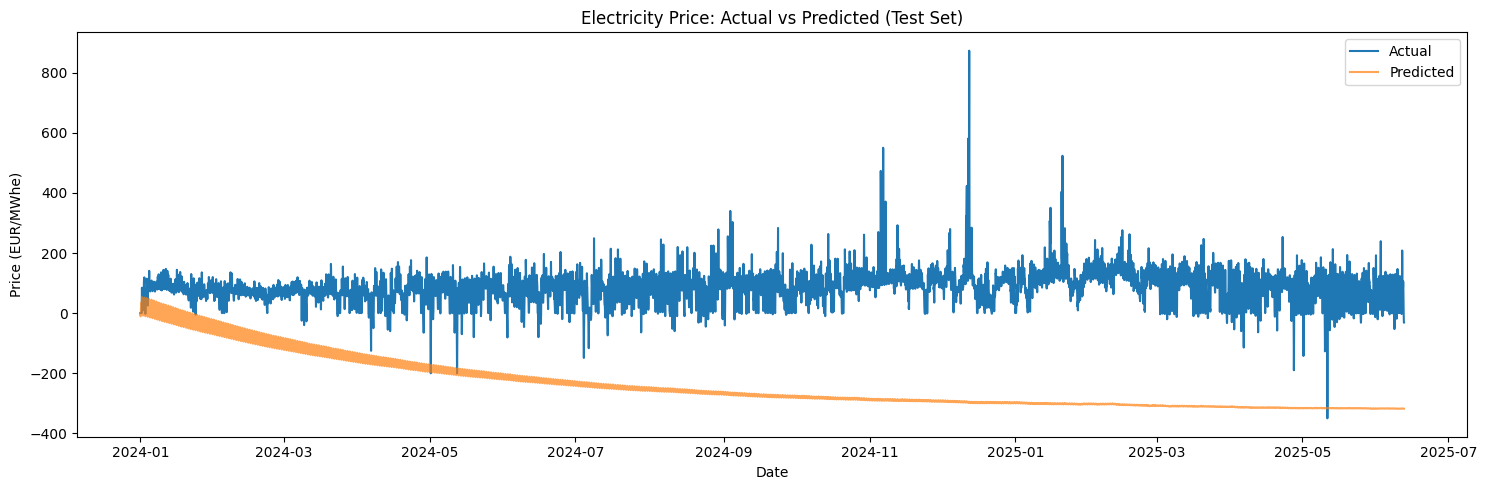


Timestamps with NaN predictions:
DatetimeIndex(['2025-06-12 13:00:00', '2025-06-12 14:00:00',
               '2025-06-12 15:00:00', '2025-06-12 16:00:00',
               '2025-06-12 17:00:00', '2025-06-12 18:00:00',
               '2025-06-12 19:00:00', '2025-06-12 20:00:00'],
              dtype='datetime64[ns]', freq=None)


In [58]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

mask = ~y_pred.isnull()
y_test_clean = y_test_aligned[mask]
y_pred_clean = y_pred[mask]

print("After removing NaNs:")
print("Clean predictions shape:", y_pred_clean.shape)
print("Original predictions shape:", y_pred.shape)

# Calculate metrics using clean data
mae = mean_absolute_error(y_test_clean, y_pred_clean)
rmse = np.sqrt(mean_squared_error(y_test_clean, y_pred_clean))

print(f"\nMetrics (excluding {y_pred.isnull().sum()} NaN predictions):")
print(f"Test MAE: {mae:.2f} EUR/MWhe")
print(f"Test RMSE: {rmse:.2f} EUR/MWhe")

# Plot with clean data
plt.figure(figsize=(15,5))
plt.plot(y_test_clean.index, y_test_clean, label='Actual')
plt.plot(y_test_clean.index, y_pred_clean, label='Predicted', alpha=0.7)
plt.legend()
plt.title('Electricity Price: Actual vs Predicted (Test Set)')
plt.xlabel('Date')
plt.ylabel('Price (EUR/MWhe)')
plt.tight_layout()
plt.show()

# Optionally, show where the NaN predictions occurred
if y_pred.isnull().sum() > 0:
    print("\nTimestamps with NaN predictions:")
    print(y_pred[y_pred.isnull()].index)